In [1]:
import dctkit as dt
from dctkit import config
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.dec import cochain as C
from dctkit.dec.vector import flat_PDP as flat
from matplotlib import cm
import pysindy as ps

In [3]:
x_max = 5
t_max = 2
dx = 0.0025
dt = 0.0001
num_x_points = int(x_max/dx)
num_t_points = int(t_max/dt)
x = np.linspace(0, x_max, num_x_points)
t = np.linspace(0, t_max, num_t_points)

# boundary and initial conditions
u_0 = 2 * np.exp(-2 * (x - 0.5 * x_max)**2)

# viscosity coefficient
epsilon = 0.1

In [4]:
# FDM run
def FDM_run(u, epsilon, scheme="parabolic"):
    for t in range(num_t_points - 1):
        diffusion = epsilon * (u[2:, t] - 2 * u[1:-1, t] + u[:-2, t]) / dx**2
        if scheme == "parabolic":
            flux = (u[2:, t]**2 - u[:-2, t]**2) / (4*dx)
        elif scheme == "upwind":
            flux = (u[1:-1, t]**2 - u[:-2, t]**2) / (2*dx)
        u[1:-1, t+1] = u[1:-1, t] + dt * (diffusion - flux)
    return u

In [5]:
u = np.zeros([num_x_points, num_t_points]) 
# Initial condition
u[:, 0] = 2 * np.exp(-2 * (x - 0.5 * x_max)**2)  
# Boundary condition at x=0
u[0, :] = 0
# Boundary condition at x=xmax
u[-1, :] = 0 

u = FDM_run(u, 0.03, scheme = "parabolic")
u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)

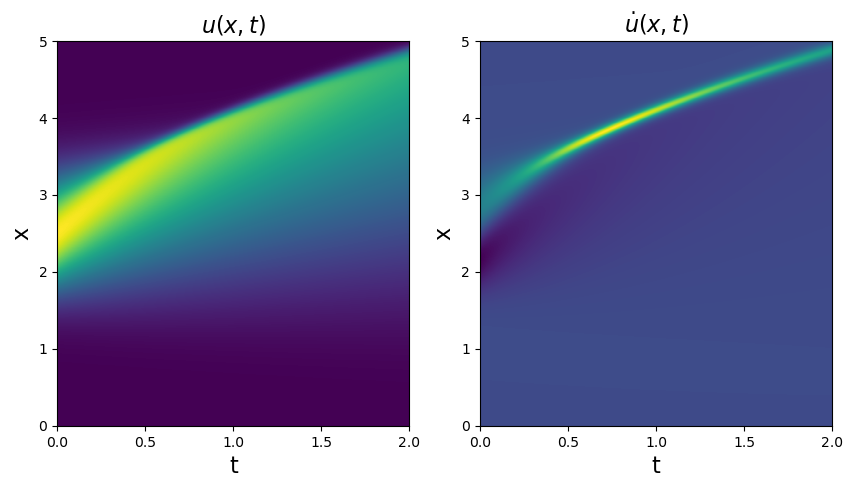

In [103]:
½b

In [6]:
u = u.reshape(len(x), len(t), 1)
u.shape

(2000, 20000, 1)

In [35]:
skip = 20
u_1 = u[::skip,::skip]
u_1.shape

(100, 1000, 1)

In [39]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=5,
    spatial_grid=x[::skip],
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True, verbose=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
#model.fit(u, t=dt, x_dot= u_dot)
model.fit(u_1, t=skip*dt)
model.print()

STLSQ model: 
 Iteration ... |y - Xw|^2 ...  a * |w|_2 ...      |w|_0 ... Total error: |y - Xw|^2 + a * |w|_2
         0 ... 1.1747e+02 ... 1.8684e+00 ...         16 ... 1.1934e+02
         1 ... 1.1666e+02 ... 1.8581e+00 ...         15 ... 1.1851e+02
         2 ... 1.1461e+02 ... 1.8610e+00 ...         15 ... 1.1647e+02
(x0)' = 0.058 x0 + -0.055 x0x0 + -0.073 x0_1 + 0.021 x0_11 + -0.900 x0x0_1 + -0.020 x0x0x0_1 + 0.011 x0x0_11 + -0.008 x0x0x0_11 + 0.001 x0x0_111


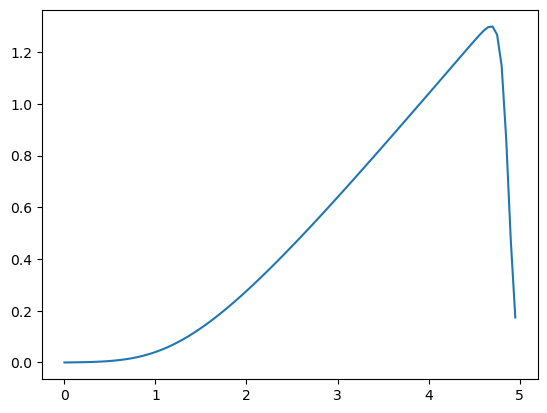

In [36]:
plt.plot(x[::skip], u_1[:,-1])